Companion notebook for the paper "Critical Role of local Monte Carlo steps in machine-learning-driven Sequential Tempering"

Python version: 3.6.9 

Packages used:

- torch: 1.10.2+cu102
- numpy: 1.19.5
- matplotlib: 3.3.4

# Imports and definitions

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

In [17]:
# transition matrix for the Markov chain
def get_transition_matrix_absm(N, beta):
    """
    Get the transition matrix for the system in magnetization space.

    Parameters:
    - N (int): The number of spins in the system.
    - beta (float): The inverse temperature (1/kT) of the system.

    Returns:
    - torch.Tensor: A transition matrix of shape ((N/2)+1, (N/2)+1) representing 
                  the probabilities of transitioning between different magnetization states.
    """
    P = torch.zeros((int(N/2)+1, int(N/2)+1))

    for i in range(0, int(N/2)+1):
        m = i*2/N
        if i == 0:
            P[i, 1] = 1
        else: 
            P[i, i-1] = (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N))
            P[i, i] = 1 - (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N)) - (1-np.abs(m))/2
            if i != N/2:
                P[i, i+1] = (1-np.abs(m))/2
    return P

#Thomas method for solving the system of equations in the form of (A7)

def thomas_solve(A):
    """
    Solves Ax = d where A is a tridiagonal matrix and d is a vector of ones.

    Arguments:
    - A: Tridiagonal matrix (torch tensor of shape (n, n))

    Returns:
    - x: Solution vector
    """
    n = A.shape[0]  # Number of equations

    # Extract the diagonals
    a = torch.zeros(n, dtype=torch.float32)
    b = torch.zeros(n, dtype=torch.float32)
    c = torch.zeros(n, dtype=torch.float32)

    for i in range(n):
        b[i] = A[i, i]  # Main diagonal
        if i > 0:
            a[i] = A[i, i - 1]  # Sub-diagonal
        if i < n - 1:
            c[i] = A[i, i + 1]  # Super-diagonal

    # Right-hand side vector d (all ones)
    d = torch.ones(n, dtype=torch.float32)

    # Temporary storage for modified coefficients
    c_prime = torch.zeros(n, dtype=torch.float32)
    d_prime = torch.zeros(n, dtype=torch.float32)

    # Forward sweep
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]

    for i in range(1, n):
        denom = b[i] - a[i] * c_prime[i - 1]
        c_prime[i] = c[i] / denom if i < n - 1 else 0  # c[n-1] is unused
        d_prime[i] = (d[i] - a[i] * d_prime[i - 1]) / denom

    # Back substitution
    x = torch.zeros(n, dtype=torch.float32)
    x[-1] = d_prime[-1]

    for i in range(n - 2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i + 1]
    

    return x

#binomial coefficient
def comb(n, k):
    """Compute the binomial coefficient 'n choose k'."""
    if k > n or k < 0:
        return 0
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

# Computations

In [32]:
beta = 1.1 # inverse temperature of interest
Nvalues = [200, 500, 1000, 2000, 5000, 10000] # values of N to consider
m_max_values = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04] #maximum magnetization for each N

all_data = []
for i in range(len(Nvalues)):

    N = Nvalues[i]
    m_max = m_max_values[i]
    transition_matrix = get_transition_matrix_absm(N, beta)

    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        nmax = int(N*m/2)

        #first passage time for Metropolis
        P = transition_matrix[:nmax, :nmax]
        fpt_metro = thomas_solve(torch.eye(P.size(0))-P)[0]

        # first passage time for MADE
        k1 = int(N*(1+m)/2)
        k2 = int(N*(1-m)/2)
        fpt_made = 1/((comb(N, k1) + comb(N, k2))/2**N)

        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)

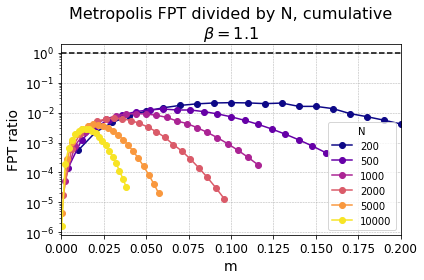

In [33]:
#plt.scatter(data[:,0]/N, data[:,2], label = "Made")

colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:,0]/Nvalues[i], d[:,1]/d[:,2]/Nvalues[i], marker='o', label=f"{Nvalues[i]}", color=color)

plt.axhline(y=1, color='black', linestyle='--')
plt.yscale("log")
#plt.ylim(10**(-2), 10**2)
plt.xlim(0, 0.20)
plt.xlabel('m', fontsize=14)
plt.ylabel('FPT ratio', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title="N")
plt.title(f"Metropolis FPT divided by N, cumulative\n$\\beta={beta}$", fontsize=16)
plt.tight_layout()
#plt.savefig('fpt_ratio_divN_cumulative.png')
